# MSE Time Series and Advection
This looks at how near-surface MSE develops with time throughout the year

In [2]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import xrscipy.signal.extra 
from scipy import interpolate
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [3]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'precipitation', 'omega', 'ucomp', 'vcomp', 'convflag', 'klzbs', 't_surf']  
# Load dataset
tau_lw = [1]
n_exp = len(tau_lw)
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'
exp_dir = 'aquaplanet/no_wishe/'
# exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

# exp_dir = 'rossbypalooza/variable_evap_flux/evap=0/'
# exp_name=''

use_time_start = 360*2
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_base += [ds_use.sel(time=slice(use_time_start, np.inf))]      # only keep after spin up

100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

Removing height from var_keep
Removing convflag from var_keep
Removing klzbs from var_keep


In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

## Fig 3 - Potential Temperature plots
Plot how variance and skewness vary with latitude

In [5]:
p_approx = [1000, 850]
n_pressure = len(p_approx)
n_lat = int(ds_base[0].lat.size)
summer_months = [6, 7, 8]

temp_mean = {key2: {key: np.zeros((n_exp, n_pressure, n_lat)) for key in ['all', 'nh_summer']} for key2 in ['temp', 'pot_temp']}
temp_var = {key2: {key: np.zeros((n_exp, n_pressure, n_lat)) for key in ['all', 'nh_summer']} for key2 in ['temp', 'pot_temp']}
temp_skew = {key2: {key: np.zeros((n_exp, n_pressure, n_lat)) for key in ['all', 'nh_summer']} for key2 in ['temp', 'pot_temp']}
with tqdm(total=n_exp*2*2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds_base[i].sel(pfull=p_approx, method='nearest')[['temp']].load()
        ds_use['pot_temp'] = potential_temp(ds_use.temp, ds_use.pfull*100)
        ds_use_anom = anom_from_annual_mean(ds_use, combine_lon='aqua' in exp_dir)
        # if bandpass_filter:
        #     # DON'T UNDERSTAND PARAMETER USED IN THESE FILTERS BUT GIVE SIMILAR RESULT TO SCHNEIDER
        #     ds_filt = xrscipy.signal.extra.highpass(ds_use, 0.01, dim='time')        # get rid of low frequency so annual cycle
        #     ds_filt = xrscipy.signal.extra.lowpass(ds_filt, 0.1, dim='time')              # get rid of high frequency so daily variation
        # else:
        #     ds_filt = ds_use
        for key in ['all', 'nh_summer']:
            if 'summer' in key:
                ds_use = annual_time_slice(ds_use, summer_months)
                ds_use_anom = annual_time_slice(ds_use_anom, summer_months)
            for key2 in ['temp', 'pot_temp']:
                temp_mean[key2][key][i] = ds_use[key2].mean(dim=['lon', 'time'])
                # Follow tamarin-brodsky_2019 and compute variance from anomaly from annual mean
                # Different from schneider bandpass filtering
                temp_var[key2][key][i] = (ds_use_anom[key2]**2).mean(dim=['lon', 'time'])
                temp_skew[key2][key][i] = (ds_use_anom[key2]**3).mean(dim=['lon', 'time'])/temp_var[key2][key][i]**(3/2)
                pbar.update(1)
p_exact = ds_use.pfull.to_numpy()

100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


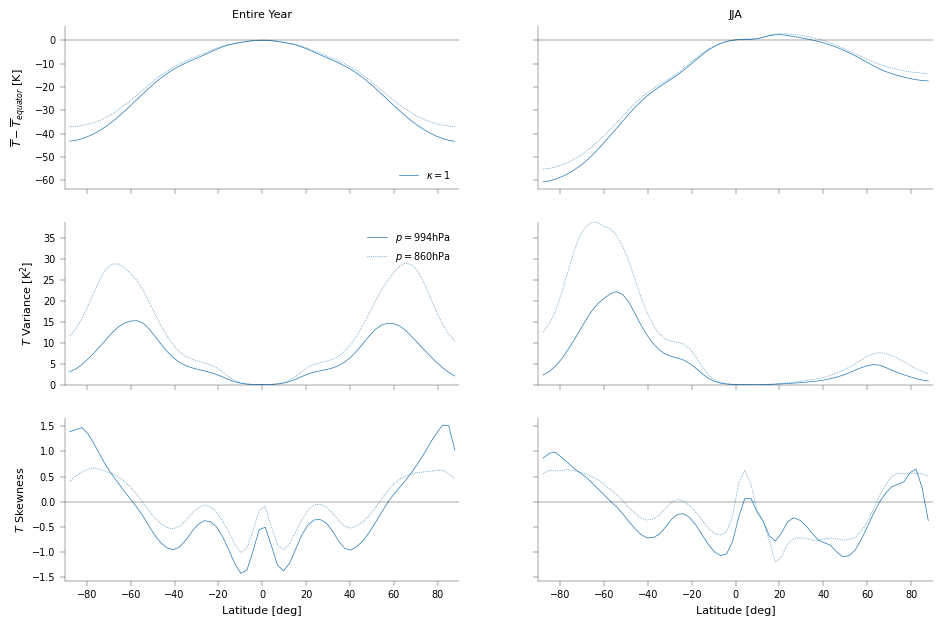

In [6]:
plot_var = 'temp'
norm_mean = True
norm_lat_ind = int(np.abs(ds_base[0].lat).argmin())
linestyle_p = ['-', ':']
fig, ax = plt.subplots(3, 2, figsize=(3.5*width['one_col'],3*width['one_col']/ar), sharex=True, sharey='row')
for i, key in enumerate(temp_mean[plot_var]):
    for j in range(n_exp):
        for k in range(n_pressure):
            ax[0, i].plot(ds_base[0].lat, temp_mean[plot_var][key][j, k]-norm_mean*temp_mean[plot_var][key][j, k, norm_lat_ind],
                          color=default_colors[j], linestyle=linestyle_p[k], label=f'$\kappa={tau_lw[j]}$' if k==0 else None)
            ax[1, i].plot(ds_base[0].lat, temp_var[plot_var][key][j, k], color=default_colors[j], linestyle=linestyle_p[k],
                          label=f'$p={int(p_exact[k])}$hPa' if j==0 else None)
            ax[2, i].plot(ds_base[0].lat, temp_skew[plot_var][key][j, k], color=default_colors[j], linestyle=linestyle_p[k])
ax[0, 0].set_xlim(-90, 90)
ax[1, 0].set_ylim(0, temp_var[plot_var]['nh_summer'].max())
for i in range(2):
    if norm_mean:
        ax[0, i].axhline(0, color='k', lw=ax_linewidth)
    ax[2, i].axhline(0, color='k', lw=ax_linewidth)
    ax[-1, i].set_xlabel('Latitude [deg]')
ax[0, 0].set_ylabel('$\overline{T} - \overline{T}_{equator}$ [K]' if norm_mean else '$\overline{T}$')
ax[1, 0].set_ylabel("$T$ Variance [K$^2$]")
ax[2, 0].set_ylabel("$T$ Skewness")
ax[0, 0].legend(loc='lower right')
ax[1, 0].legend(loc='upper right')
ax[0, 0].set_title('Entire Year')
ax[0, 1].set_title('JJA');

## Relation between Skewness and Temperature Distribution


In [7]:
lat_plot = 17
lon_plot = 0
ds_single_lat = ds_base[0].sel(lat=lat_plot, method='nearest').temp.isel(pfull=-1)

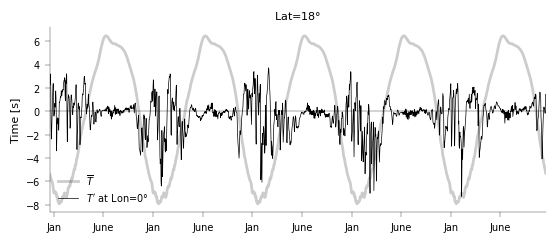

In [8]:
save_temp_timeseries_fig = False

fig, ax = plt.subplots(1, 1, figsize=(2*width['one_col'],width['one_col']/ar))
ds_use = annual_mean(ds_single_lat).mean(dim='lon')
ax.plot(ds_base[0].time, np.tile(ds_use-ds_use.mean(), 5), label='$\overline{T}$', color='k', alpha=0.2, lw=2)
ds_use = anom_from_annual_mean(ds_single_lat, combine_lon='aqua' in exp_dir).sel(lon=lon_plot, method='nearest')
ax.plot(ds_use.time, ds_use, label=f"$T'$ at Lon={int(ds_use.lon)}$\degree$", color='k')
ax.set_title(f'Lat={int(ds_single_lat.lat)}$\degree$')
ax.legend()
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlim(ds_use.time.min(), ds_use.time.max())
ax.set_ylabel('Temperature [K]')
ax.set_ylabel('Time [s]')
# time_annual_mean = ds_annual_mean.time-0.5
ticks_use = (np.arange(15, 195+180*(5*2-1), 180)+float(ds_use.time[0]), ['Jan','June']*5)
ax.set_xticks(*ticks_use)

if save_fig or save_temp_timeseries_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_timeseries_lat={lat_plot}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

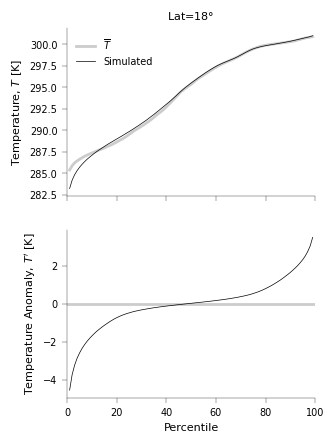

In [9]:
quant_plot = np.arange(1, 100)

save_temp_single_lat_quant_fig = False
fig, ax = plt.subplots(2, 1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ds_use = annual_mean(ds_single_lat).stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
ds_use = ds_use.quantile(quant_plot/100, dim='lon_time')
ax[0].plot(quant_plot, ds_use, color='k', alpha=0.2, lw=2, label='$\overline{T}$')
ds_use = ds_single_lat.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
ds_use = ds_use.quantile(quant_plot/100, dim='lon_time')
ax[0].plot(quant_plot, ds_use, color='k', label='Simulated')

ds_use = anom_from_annual_mean(ds_single_lat, combine_lon='aqua' in exp_dir
                               ).stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
ds_use = ds_use.quantile(quant_plot/100, dim='lon_time')
ax[1].plot(quant_plot, ds_use, color='k')
ax[1].axhline(0, color='k', lw=2, alpha=0.2)
ax[0].set_xlim(0, 100)
ax[0].legend()
ax[1].set_xlabel('Percentile')
ax[0].set_ylabel('Temperature, $T$ [K]')
ax[1].set_ylabel("Temperature Anomaly, $T'$ [K]")
ax[0].set_title(f'Lat={int(ds_single_lat.lat)}$\degree$')

if save_fig or save_temp_single_lat_quant_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_quant_lat={lat_plot}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [10]:
ds_use = annual_mean(ds_base[0].sel(lat=lat_plot, method='nearest')[['temp', 't_surf', 'sphum']].isel(pfull=[-1, -13])).mean(dim='lon')

In [12]:
temp_surf_conv = get_temp_adiabat_surf(ds_use.sphum[:, 0], ds_use.temp[:, 1], None, float(ds_use.pfull[0]*100), float(ds_use.pfull[1]*100), False)

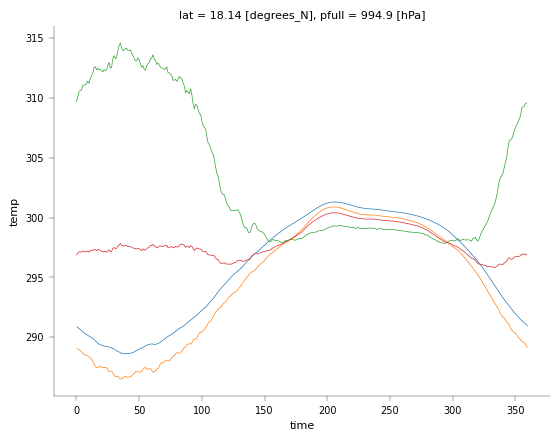

In [16]:
ds_use.t_surf.plot()
ds_use.temp[:, 0].plot()
plt.plot(temp_surf_conv)
plt.plot(temp_surf_conv2)

In [15]:
r_surf = ds_use.sphum[:, 0]/sphum_sat(ds_use.temp[:, 0], ds_use.pfull[0]*100)
temp_surf_conv2 = np.zeros(360)
for i in tqdm(range(360)):
    temp_surf_conv2[i] = get_temp_adiabat_surf(float(r_surf[i]), float(ds_use.temp[i, 1]), None, float(ds_use.pfull[0]*100), 
                                               float(ds_use.pfull[1]*100), True)

  0%|          | 0/360 [00:00<?, ?it/s]/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_13062/3838054296.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temp_surf_conv2[i] = get_temp_adiabat_surf(float(r_surf[i]), float(ds_use.temp[i, 1]), None, float(ds_use.pfull[0]*100),
100%|██████████| 360/360 [02:36<00:00,  2.30it/s]


In [ ]:
temp_ft_pred = np.zeros(360)
for i in tqdm(range(360)):
    temp_ft_pred[i] = get_temp_adiabat(float(ds_use.temp[i, 0]), float(ds_use.sphum[i, 0]), 
                                       float(ds_use.pfull[0]*100), float(ds_use.pfull[1]*100))

In [ ]:
plt.plot(temp_ft_pred)
plt.plot(ds_use.temp[:, 1])